In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import re
import seaborn as sns

from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score

## Loading data

In [3]:
X_train = pd.read_csv("../../train_features_emo.csv")
X_test = pd.read_csv("../../test_features_emo.csv")

df_train = pd.read_csv('../../train_emo_clean')
df_test = pd.read_csv('../../test_emo_clean.csv')


mean = X_train.mean(axis=0)
std = X_train.std(axis=0)

X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

labels = sorted((df_train['Emotion'].unique()).tolist())
id2label = {idx:label for idx, label in enumerate(labels)}
label2id = {label:idx for idx, label in enumerate(labels)}

y_test = df_test['Emotion'].replace(label2id)
y_train = df_train['Emotion'].replace(label2id)

In [4]:
X_train = X_train.values.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.values.reshape(X_test.shape[0], 1, X_test.shape[1])

X_train = torch.Tensor(X_train)
y_train = torch.tensor(y_train)

## Model class

In [5]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=1)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(3186 * 32, 128)
        self.fc2 = nn.Linear(128, 7)
        
    def forward(self, x):                  # [32, 1, 6373]
        x = torch.relu(self.conv1(x))      # [32, 32, 6373]
        x = self.pool(x)                   # [32, 32, 3186]
        x = self.flat(x)                   # [32, 101952]
        x = torch.relu(self.fc1(x))        # [32, 128]
        x = self.fc2(x)                    # [32, 7]
        return x

## Train model

In [ ]:
num_epochs = 50
batch_size = 128

In [ ]:
model = ConvNet()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

checkpoint_path = "model_checkpoint"

train_data = TensorDataset(X_train, y_train.long())
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs):
    running_loss = 0.0
    running_corrects = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = running_corrects.double() / len(train_data)
    print('Epoch [%d], loss: %.3f, acc: %.3f' % (epoch+1, epoch_loss, epoch_acc))
    
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': epoch_loss,
            'accuracy': epoch_acc,
            }, checkpoint_path+str(epoch)+'.pt')

## Load model

In [ ]:
model = ConvNet()
optimizer = optim.Adam(model.parameters())

checkpoint = torch.load('1d_cnn_with_opensmile.pt')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

model.eval()

In [30]:
test_inputs = torch.tensor(X_test, dtype=torch.float)

# Example usage: make predictions for the test dataset
with torch.no_grad():
    outputs = model(test_inputs)
    _, predicted = torch.max(outputs, 1)
    y_pred = predicted
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'F-1 score: {f1:.2f}')

F-1 score: 0.37


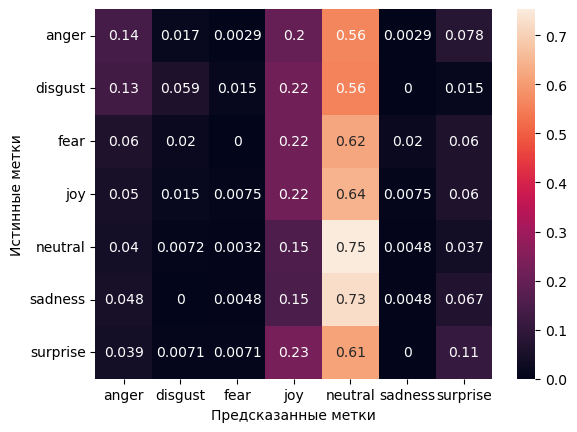

In [31]:
labels = sorted((df_train['Emotion'].unique()).tolist())

cm = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(cm, annot=True, xticklabels=sorted(labels), yticklabels=sorted(labels))
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()